# Analyse avec K-means

**But :** Trouver les différents clusters depuis les images précédements extraites des vidéos

### TODO

K-means -> comparer avec label

In [2]:
from os import listdir
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_samples, silhouette_score

### Chargement des images

In [2]:
img_path = "../data/videos/labelised/all"

In [3]:
# TODO passer en niveau de gris

def load_images(path):
    files = listdir(path)    
    images = [plt.imread(f"{path}/{i}")[:,:,0] for i in files]
    images = np.asarray([i for i in images])
    print(images.shape)

    nb, height, width = images.shape
    dataset = images.reshape(nb, height*width)

    return (dataset, files)

In [4]:
dataset, files = load_images(img_path)

dataset.shape

(1651, 480, 640)


(1651, 307200)

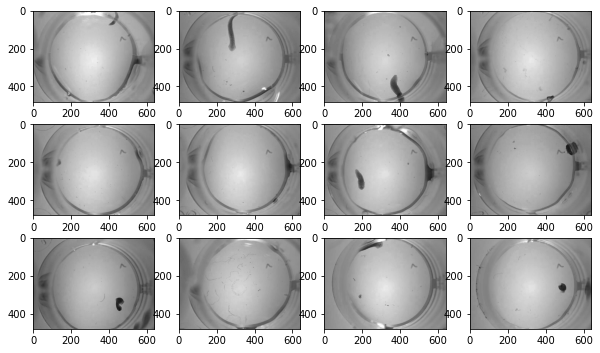

In [5]:
plt.figure(figsize=(10,100))
compt=0
for i in range(0,12):
    img=dataset[i].reshape(480,640)
    plt.subplot(48,4,i+1)
    compt=compt+1
    plt.imshow(img, cmap='gray')
    
plt.show()

### ACP

In [6]:
ipca = IncrementalPCA(n_components=50, batch_size=100)
X_ipca = ipca.fit_transform(dataset)
var = ipca.explained_variance_ratio_.cumsum()

variance preserved by 50 components: 0.894


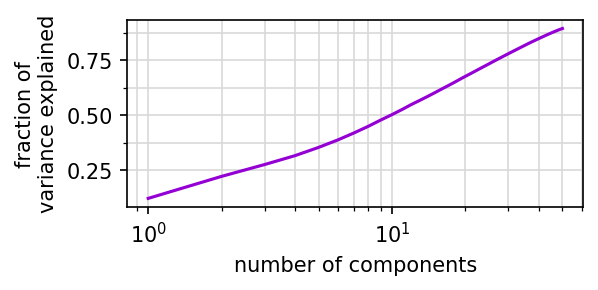

In [7]:
fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var)+1), var, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)


fig.tight_layout()
print('variance preserved by 50 components: {:.3f}'.format(var[49]))

### Clustering

Determiner les K clusters avec TSNE

In [72]:
def find_k_clusters(range_max, X, full_graph=True):
    range_n_clusters = range(2, range_max)
    
    silhouette_scores = []
    best_avg_silh = 0
    optimal_clusters = 2

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=30, max_iter=600)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > best_avg_silh:
            best_avg_silh = silhouette_avg
            optimal_clusters = n_clusters


        silhouette_scores.append(silhouette_avg)

        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )


        if full_graph:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker="$%d$" %
                            i, alpha=1, s=50, edgecolor="k")

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(
                "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                % n_clusters,
                fontsize=14,
                fontweight="bold",
            )

    if full_graph:
        plt.show()

    fig, ax = plt.subplots()
    y_pos = np.arange(2, len(silhouette_scores)+2)
    ax.bar(y_pos, silhouette_scores)
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Score de silhouette')
    ax.set_title('Score de silhouette par cluster')
    plt.show()
    
    return optimal_clusters


In [84]:
optimal_clusters = find_k_clusters(15, X_ipca, full_graph=False)

For n_clusters = 2 The average silhouette_score is : 0.11527427455401837
For n_clusters = 3 The average silhouette_score is : 0.137499459645452
For n_clusters = 4 The average silhouette_score is : 0.128240222500724
For n_clusters = 5 The average silhouette_score is : 0.1443309202963997
For n_clusters = 6 The average silhouette_score is : 0.15904830532586647
For n_clusters = 7 The average silhouette_score is : 0.16807749246394751
For n_clusters = 8 The average silhouette_score is : 0.1815661918278413
For n_clusters = 9 The average silhouette_score is : 0.1963022196875396
For n_clusters = 10 The average silhouette_score is : 0.19885261797105125
For n_clusters = 11 The average silhouette_score is : 0.19585175329728777
For n_clusters = 12 The average silhouette_score is : 0.23068266180537042
For n_clusters = 13 The average silhouette_score is : 0.2231953524913923
For n_clusters = 14 The average silhouette_score is : 0.2239352114676519
For n_clusters = 15 The average silhouette_score is : 0

In [75]:
def extract_clusters(img_path, nb_cluster, cluster_labels, files):
    result_path = "../clustering"
    for i in range(nb_cluster):
        Path(f"{result_path}/{i}").mkdir(parents=True, exist_ok=True)
    
    for idx, label in enumerate(cluster_labels):
        img_name = files[idx]
        shutil.copyfile(f"{img_path}/{img_name}",f"{result_path}/{label}/{img_name}")

In [77]:
optimal_clusters

13

In [78]:
clusterer = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=30, max_iter=600)
cluster_labels = clusterer.fit_predict(X_ipca)
extract_clusters(img_path, optimal_clusters, cluster_labels, files)

TODO : score silhouette equation